## Gain tuning of PID control by model-matching
Reference:  
[1] http://y373.sakura.ne.jp/minami/pyctrl  
[2] "Pythonによる制御工学入門(第1版)", 南裕樹, オーム社  
[3] "Control Engineering: MATLAB Exercies", Laszlo.K et al, Springer

Let us assume the vertically pinned arm that we discussed in the previous section. PID parameters were given to be appropreately control the system. But what if we have to tune those parameters manually?

In those situations, one of the useful methods is "model matching" method. Model matching tunes the PID parameters so that the transfer function of the system $G_{yr}(s)$ gives the (nearly) same output. The model reference system is represented as $M(s)$. If the model reference system is second order lag system, then:

$$
M(s) = \frac{\omega_n^2}{s^2 + 2\zeta\omega_ns + \omega_n^2}
$$
McLaughlin expansion of $\frac{1}{G_{yr}(s)}$ is set to be nearing to that of and $\frac{1}{M(s)}$ from the lower order terms.

Now thinks about PI-D control of the arm. The transfer function from reference input $r$ to the output $y$ is:
$$
G_{yr}(s) = \frac{k_Ps+k_I}{Js^3 + (\mu+k_D)s^2 + (Mgl+k_P)s + k_I}
$$
McLaughlin expansion of $\frac{1}{G_{yr}(s)}$ is:
$$
\frac{1}{G_{yr}(s)} = 1 + \frac{Mgl}{k_I}s + (\frac{\mu+k_D}{k_I} - Mgl\frac{k_P}{k_I^2})s^2 + (\frac{J}{k_I}-\frac{k_P(\mu+k_D)}{k_I^2} + Mgl\frac{k_P^2}{k_I^3})s^3 + O(s^4)
$$
On the other hand, McLaughlin expansion of $\frac{1}{M(s)}$ is:
$$
\frac{1}{M(s)} = 1 + \frac{2\zeta}{\omega_n}s + \frac{1}{\omega_n^2}s^2
$$

By solving $1/G_{yr} = 1/M$, we get:
$$
k_P = \omega_n^2J, \quad k_I = \frac{\omega_nMgl}{2\zeta}, \quad k_D = 2\zeta\omega_nJ + \frac{Mgl}{2\zeta\omega_n} - \mu
$$

Let us observe the result of this model matching method below.

In [7]:
import control.matlab as ctrl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

g = 9.81
l = 0.2
M = 0.5
mu = 1.5e-2
J = 1.0e-2
ref = 30

In [2]:
s = sp.Symbol('s')
kp, kd, ki = sp.symbols('k_p k_d k_i')
Mgl, mu, J = sp.symbols('Mgl mu J')
sp.init_printing()

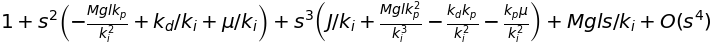

In [3]:
# McLaughlin expansion of Gyr
G = (kp*s+ki)/(J*s**3 + (mu+kd)*s**2 + (Mgl + kp)*s + ki)
sp.series(1/G, s, 0, 4)  # the result matches with the McLaughlin expansion above

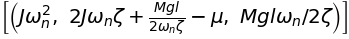

In [4]:
# model matching of 1/Gyr(s) to 1/M(s)
z, wn = sp.symbols('zeta omega_n')
sp.init_printing()

f1 = Mgl/ki -2*z/wn
f2 = (mu+kd)/ki - Mgl*kp/(ki**2) - 1/(wn**2)
f3 = J/ki - kp*(mu+kd)/(ki**2) + Mgl*kp**2/(ki**3)
sp.solve([f1, f2, f3], [kp, kd, ki])

The above chunk of code gave us:
$$
k_P = \omega_n^2J, \quad k_I = \frac{\omega_nMgl}{2\zeta}, \quad k_D = 2\zeta\omega_nJ + \frac{Mgl}{2\zeta\omega_n} - \mu
$$

This yields the comparison of each output of $G_{yr}(s), M(s)$ as following:

[2.25, 10.406647807637908] [0.01, 0.2583517680339462, 3.231, 10.406647807637908]


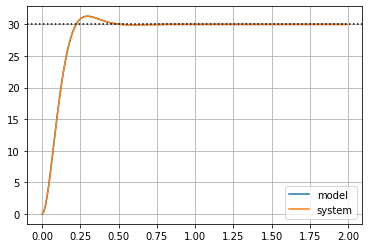

In [8]:
# model reference system
omega_n = 15
zeta = 0.707
Msys = ctrl.tf([0, omega_n**2], [1, 2*zeta*omega_n, omega_n**2])

# the sytem (Gyr(s))
kp = omega_n**2 * J
kd = 2*J*omega_n*zeta + (M*g*l)/(2*omega_n*zeta)-mu
ki = M*g*l*omega_n/(2*zeta)
num = [kp, ki]
den = [J, mu+kd, M*g*l+kp, ki]
print(num, den)
Gyr = ctrl.tf([kp, ki], [J, mu+kd, M*g*l+kp, ki])

y_model, t_model = ctrl.step(Msys, np.arange(0, 2, 0.01))
y, t = ctrl.step(Gyr, np.arange(0, 2, 0.01))

plt.plot(t_model, y_model*ref, label="model")
plt.plot(t, y*ref, label="system")
plt.legend()
plt.axhline(ref, linestyle=":", color="k")
plt.grid()
plt.show()  # output of model and system exactly match